# Avi Skidelsky
# Nosson Weissman

# DAV-6150 Module 8 Assignment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as m
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from numpy.random import seed
from numpy.random import randn
from numpy import exp
from scipy.stats import boxcox
from scipy import stats
from scipy.special import boxcox1p
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%matplotlib inline

# Introduction

The problem that we are tasked with in this scenario is interpretting for an insurance company whether a customer is likely to purchase an additional insurance product. The goal is to try and create particular segments of the data using different classification algorithms to create a group of customers to target as opposed to probabilities that could be generated through a logistic regression model. In the data, we have variables like customer age, city, amount of money spent, type of contract, and various others. This includes our variable that we are trying to predict, TARGET. First importing the data, the size is approximately 14,000 rows and 15 attributes, 14 if you want to only consider the predictive variables.

1.   ID: Unique customer identifier
2.   TARGET: Indicator of buying the new product (0=no, 1=yes)
3.   Loyalty: Loyalty level, from low to high (0 to 3), 99 = unclassified
4.   Age: Age in years
5.   City: Unique code per city
6.   Age_p: Age of partner in years
7.   LOR: Length of relationship in months
8.   LOR_m: Length of relationship in months
9.   Prod_A: Bought product A (0=no, 1=yes)
10.  Type_A: Type of product A
11.  Turnover_A: Amount of money spent on product A
12.  Prod_B: Bought product B (0=no, 1=yes)
13.  Type_B: Type of product B
14.  Turnover_B: Amount of money spent on product B
15.  Contract: Type of contract


# EDA:

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/askidelsky/DAV-6150/main/Homework/Module%207/M7_Data.csv")
df.head()

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
2,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
3,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
4,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3


In [ ]:
df.shape

(14016, 15)

### Data Profiling
Looking at the data, it consists of approximately 14,000 observations, each with 15 columns, 14 attributes.

Inspecting the data types of all columns, they are all numeric with the exception of TARGET which is listed as either Y or N. This is fine as we are trying to predict Y vs N and this is easily converted into a simple 1 or 0 value. This change will take place in the data preparation stage. Note that with the exception of age, LOR, turnover_A, turnover_B, age_P, and lor_M, all are categorical variables both ordinal and nominal. Those previously mentioned are the only continuous ones.

In [ ]:
df.dtypes

TARGET         object
loyalty         int64
ID              int64
age             int64
city            int64
LOR             int64
prod_A          int64
type_A          int64
type_B          int64
prod_B          int64
turnover_A    float64
turnover_B    float64
contract        int64
age_P           int64
lor_M           int64
dtype: object

Next, looking at the amount of missing values, thankfully there are none so no imputations will be needed.

In [ ]:
df.isna().sum().sum()

0

### Data Contents and Structure

I decided to check the data for attributes with little to no variance, signaling that they won't impact the result of the model, at least not strongly. One column that is easy to eliminate off the bat is contract. Contract can be eliminated because every observation in this data set has the same value. This signals that the response variable, TARGET, does not change based on whatever this value is at least in the data provided. These steps will be taken care of in the data preparation step.

ID in theory should be unique to each observation but I decided to check anyways. In this case, there are 3,000 rows, amounting to 21.5% of all observations, that are complete duplicates. If it was a smaller percentage of observations then we wouldn't bother eliminating because it wouldn't have much of an effect but here we have no choice but to eliminate the duplicates. 

Since we are unable to provide accurate EDA while having so many duplicates, they will be removed right away as opposed to during the data preparation step. The entire column of ID will be removed since it is just an identifying column and doesn't contain meaningful values.

In [ ]:
df[df.duplicated()==True]

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
11008,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
11009,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
11010,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
11011,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
11012,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14011,Y,99,151601,30,2,0,0,0,0,0,386.434278,284.309508,2,30,3
14012,Y,1,151634,27,2,2,1,3,3,1,376.842591,266.993794,2,27,27
14013,Y,99,151679,26,2,0,0,0,0,0,434.805703,284.629361,2,26,3
14014,Y,1,151804,75,2,1,1,3,3,1,366.273857,270.573265,2,75,15


In [ ]:
1 - len(df.ID.unique())/len(df.ID)

0.21461187214611877

In [ ]:
df= df.drop_duplicates(subset=['ID'])
1 - len(df.ID.unique())/len(df.ID)

0.0

In [ ]:
cols = df[['type_A','type_B','contract']]

vals={}
for i in range(len(cols.columns)):
  vals[cols.columns[i]] = cols.iloc[:,i].unique()
vals

{'contract': array([2]),
 'type_A': array([0, 3, 6]),
 'type_B': array([0, 3, 6, 9])}

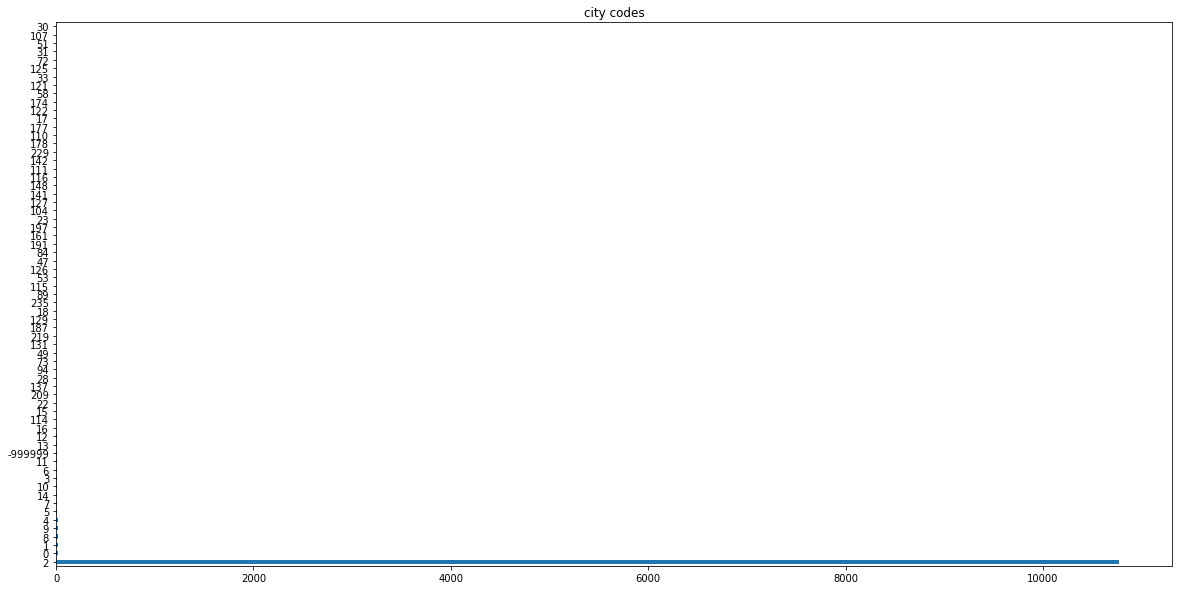

In [ ]:
df['city'].value_counts().plot(kind='barh', figsize=(20,10), title='city codes')

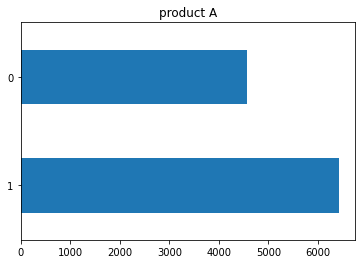

In [ ]:
df['prod_A'].value_counts().plot(kind='barh', title='product A')

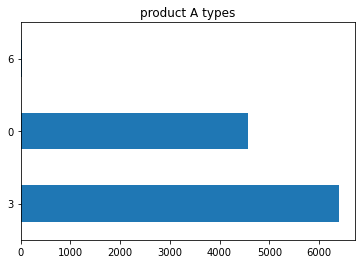

In [ ]:
df['type_A'].value_counts().plot(kind='barh', title='product A types')

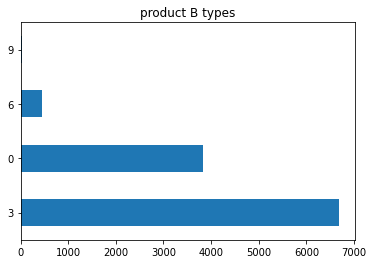

In [ ]:
df['type_B'].value_counts().plot(kind='barh', title='product B types')

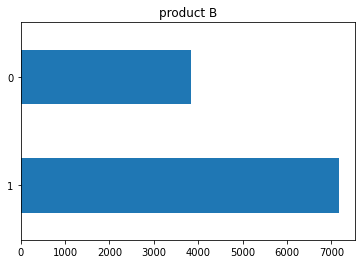

In [ ]:
df['prod_B'].value_counts().plot(kind='barh', title='product B')

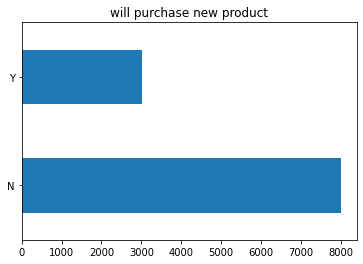

In [ ]:
df['TARGET'].value_counts().plot(kind='barh', title='will purchase new product')

Based on the bar charts above, we can see that they all have enough of a spread of values that they should be considered significant moving forward with the exception of city. While there is variance, an overwhelming majority of the observations are associated with the code "2". I decided to isolate the observations where city code is "2" below and checked out the same distributions of the variables that I did for the data set at large. After examination, they are nearly identical which leads me to believe that city isn't significant and can be removed. This is helpful going forward as we would need to create over 50 dummy variables if we had included it. This change will be reflected in the data preparation step.

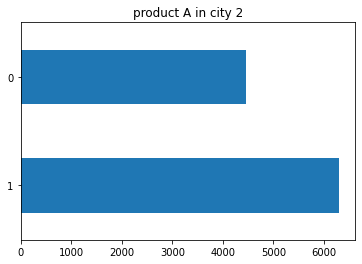

In [ ]:
city = df[df.city==2]
city['prod_A'].value_counts().plot(kind='barh', title='product A in city 2')

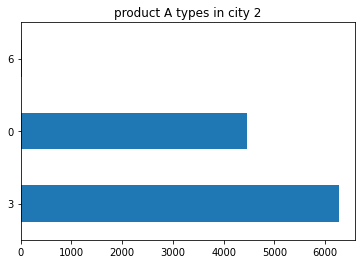

In [ ]:
city['type_A'].value_counts().plot(kind='barh', title='product A types in city 2')

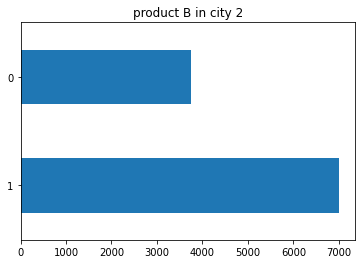

In [ ]:
city['prod_B'].value_counts().plot(kind='barh', title='product B in city 2')

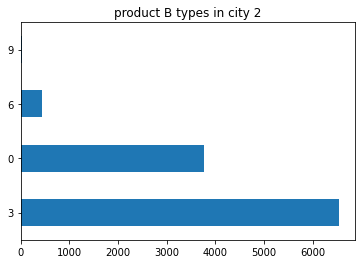

In [ ]:
city['type_B'].value_counts().plot(kind='barh', title='product B types in city 2')

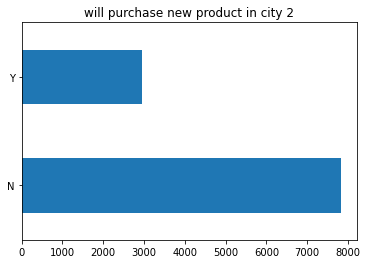

In [ ]:
city['TARGET'].value_counts().plot(kind='barh', title='will purchase new product in city 2')

Looking at these histograms describing the continuous distributions, a lot of these results are easily interpretable by considering the characteristics of each observation. For example, turnover_A and turnover_B are largely skewed to one value. A simple explanation for this is that products are typically the same price, although this isn't always true based on some other factors considered by the insurance underwriters which explains the small amount of data that is represented as other values.

age_P, the age of the other member of the insurance policy is skewed towards dependents in their 30s with the next highest values coming in around the 20s although it is noted that the skew isn't as heavy as other distributions. A possible explanation is that typically dependents on policies are spouses or children which explains the ages. age and age_P follow almost identical distributions, seeing as typically spouses who share the policy are roughly similar ages. 

What is surprising is looking at the describe box, the lowest value for age is five, what five year old has their own insurance policy? This is likely an outlier or an error on input. However, looking at the histogram for age, the count of those values is so minimal that it isn't even appearing as visual on the chart, only 7 observations amounting to only 0.05% of the overall data. An explanation for this is if a parent buys a plan for just the child for one reason or another. Looking at the boxplots below however, there are a significant amount of outliers and I don't want to shy away from them since there are significant amount of them for each attribute. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94630c5f90>,
      dtype=object)

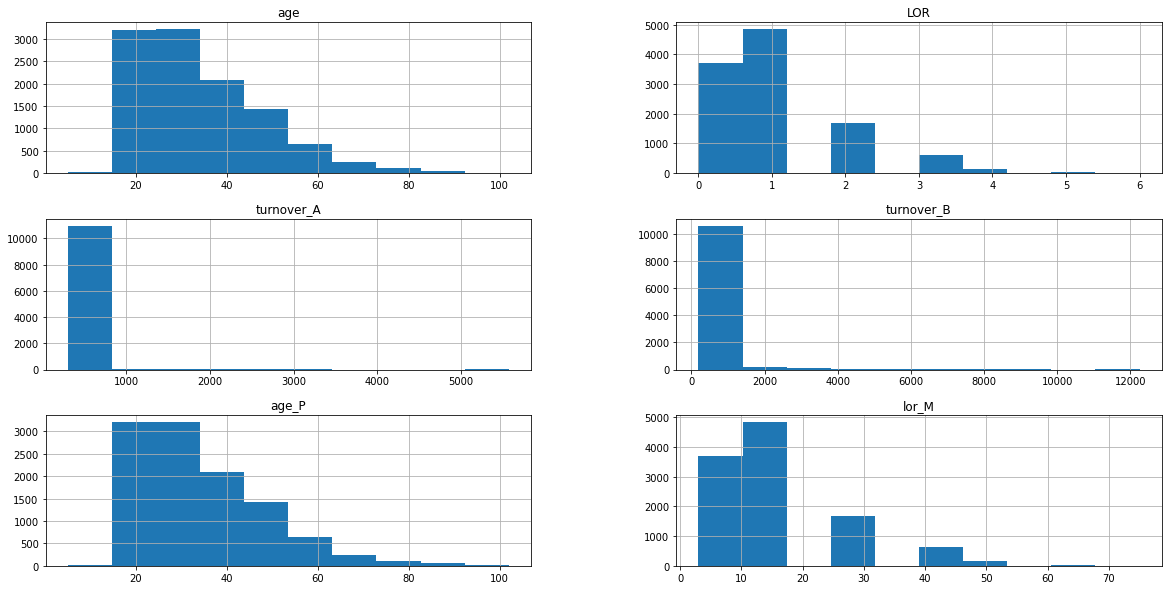

In [ ]:
nums = df[['age','LOR','turnover_A','turnover_B','age_P','lor_M']]
nums.hist(figsize=(20,10))

In [ ]:
nums.describe()

,age,LOR,turnover_A,turnover_B,age_P,lor_M
count,11008.000000,11008.000000,11008.000000,11008.000000,11008.000000,11008.000000
mean,34.845203,0.982649,372.332403,344.120565,34.845203,14.791788
std,13.032781,0.939415,96.685932,524.372413,13.032781,11.272981
min,5.000000,0.000000,300.095909,191.962852,5.000000,3.000000
25%,24.000000,0.000000,332.229899,218.302029,24.000000,3.000000
50%,31.000000,1.000000,361.930298,235.025216,31.000000,15.000000
75%,42.000000,1.000000,391.567662,253.759401,42.000000,15.000000
max,102.000000,6.000000,5568.784139,12249.084770,102.000000,75.000000


If we would take a look at some of the numeric attributes paired with the response variables, we can try and make some inferences. When it comes to spending for products A and B, both say indicate that the more that a person spends the less likely they are to purchase the new package. However, upon comparison of the two, the spread of values for turnover_B is much greater than turnover_A. While the higher price points for both fields are somewhat outliers, the outliers for turnover_A is much more severe and in general the values for turnover_A are similar. Thanks to this, we can come to an early conclusion that turnover_B will be pretty significant.

When it comes to the spread of age and the response, there is only a discrepency when the age dips below around 21. After that point, all responses are "no". This also leads my to believe that age will be significant, seeing as the value of one condition has a direct impact on the outcome.

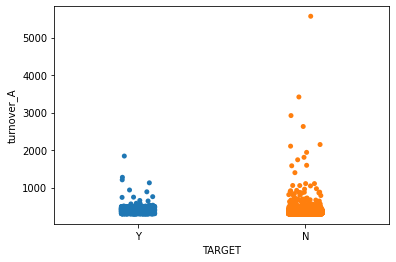

In [ ]:
sns.stripplot(x='TARGET', y='turnover_A', data=df)

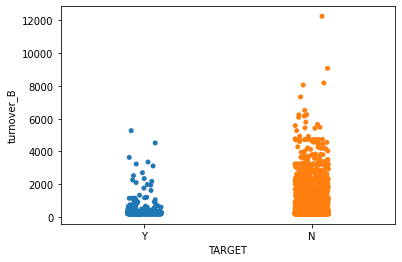

In [ ]:
sns.stripplot(x='TARGET',y='turnover_B', data=df)

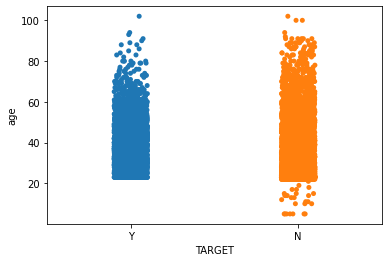

In [ ]:
sns.stripplot(x='TARGET',y='age',data=df)

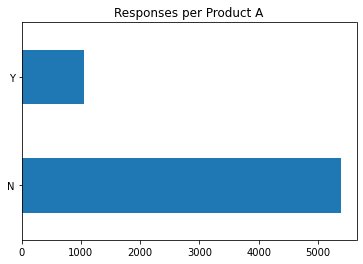

In [ ]:
df[df.prod_A==1].TARGET.value_counts().plot(kind='barh', title='Responses per Product A')

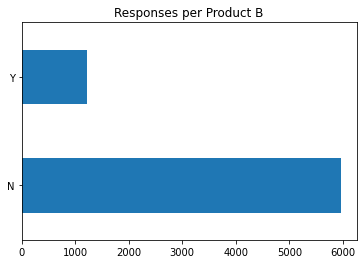

In [ ]:
df[df.prod_B==1].TARGET.value_counts().plot(kind='barh', title='Responses per Product B')

In [ ]:
df['package'] = np.where((df.prod_A==1)&(df.prod_B!=1),'A',np.where((df.prod_A!=1)&(df.prod_B==1),'B',np.where((df.prod_A!=1)&(df.prod_B!=1),'None','Both')))
df['package'].unique()

array(['None', 'Both', 'B'], dtype=object)

In [ ]:
print('No A, No B: ',len(df[(df.prod_A==0)&(df.prod_B==0)]))
print('No A, Yes B: ',len(df[(df.prod_A==0)&(df.prod_B!=0)]))
print('Yes A, No B: ',len(df[(df.prod_A!=0)&(df.prod_B==0)]))
print('Yes A, Yes B: ',len(df[(df.prod_A!=0)&(df.prod_B!=0)]))

No A, No B:  3828
No A, Yes B:  747
Yes A, No B:  0
Yes A, Yes B:  6433


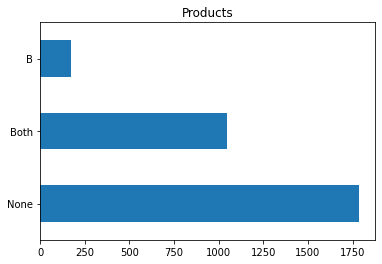

In [ ]:
df[df.TARGET=='Y'].package.value_counts().plot(kind='barh',title='Products')

Comparing the responses for products A and B, they look nearly identical which seems to indicate that something is wrong since it's highly unlikely that they would be identical. 

To check this out, I created a new column showing which products each observation owns. Interesting to note, there are no observations where the customer owns product A and not product B, they all either B, both, or none prior to study.

Charting out who is most likely to purchase product C, the customer most likely to purchase is the customer who owns neither product prior to the study. This is in line with the inference drawn above that the customer most likely to purcahse product C is the new customer.


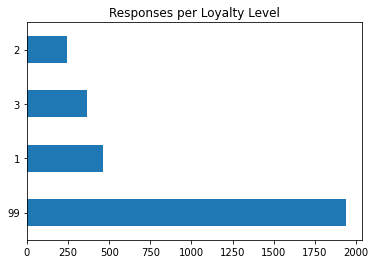

In [ ]:
df[df.TARGET=='Y'].loyalty.value_counts().plot(kind='barh', title='Responses per Loyalty Level')

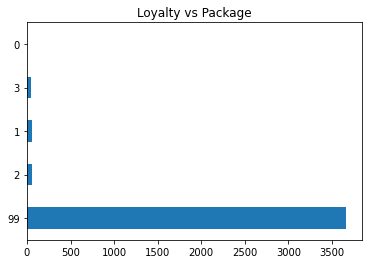

In [ ]:
df[df.package=='None'].loyalty.value_counts().plot(kind='barh',title='Loyalty vs Package')

Looking at loyalty vs response, we can see that those observations with unclassified loyalty have the highest responses of yes. 

This seems strange seeing as someone with high loyalty would be most likely to purchase this new product. Comparing loyalty level with the amount of packages owned, as was demonstrated above, nearly all customers who, prior to being observed, owned no products had the highest positive response rate. Pairing this information with the products owned chart, we can see that nearly all customers who had none of the products prior had unclassified loyalty. 

These pieces of information lead me to conclude that the customer most likely to purchase product C is a new customer who doesn't have any loyalty level to be observed.

In [ ]:
nums.corr()

,age,LOR,turnover_A,turnover_B,age_P,lor_M
age,1.000000,0.120313,0.130944,0.293546,1.000000,0.120313
LOR,0.120313,1.000000,0.024052,0.164561,0.120313,1.000000
turnover_A,0.130944,0.024052,1.000000,0.138260,0.130944,0.024052
turnover_B,0.293546,0.164561,0.138260,1.000000,0.293546,0.164561
age_P,1.000000,0.120313,0.130944,0.293546,1.000000,0.120313
lor_M,0.120313,1.000000,0.024052,0.164561,0.120313,1.000000


To examine any more variables before creating tons of dummies, we will check out a correlation matrix to see if there may be colinearity. There are two concerns of multicolinearity between age and age_P and LOR and lor_M. Neither age or age_P will be eliminated at this point since they are describing two different aspects of each observation. 

However, the connection between LOR and lor_M is concerning since LOR is essentially just lor_M divided by 12, length being expressed in years instead of months. I don't think that it's necessary to include both of these and since I want to preserve both possible relationships, I will remove LOR since lor_M encompasses both pieces of information on a more granular level while LOR only expresses one piece of information on a very general sense. This change will occur in data preparation.

# Data Preparation

### Removing Variables

As mentioned in steps above, city, and contract can be eliminated because they provide no new information for each observation after we eliminated all duplicates. Contract is a constant value of "2". City can be dropped because even though not all observations are of the same value, an overwhelming majority of them are and by using city and creating over 50 dummy variables, we would be introducing a lot of unnecessary noise.

In [ ]:
df = df.drop(columns=['ID','contract', 'city']).copy()
df.head()

,TARGET,loyalty,age,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,age_P,lor_M,package
0,Y,99,66,0,0,0,0,0,333.561114,264.721010,66,3,None
1,Y,1,45,3,1,3,3,1,394.735699,284.904978,45,39,Both
2,Y,1,42,2,1,3,6,1,342.180990,1175.589721,42,27,Both
3,Y,99,31,0,0,0,0,0,453.757916,242.341754,31,3,None
4,Y,99,62,0,0,0,0,0,384.577469,287.008370,62,3,None


Also mentioned above, LOR and lor_M have too strong of a connection to both be included and if both are included, will likely introduce a lot of unnecessary noise and multicollinearity. For this reason, I decided to remove LOR since lor_M encompasses all of the information.

In [ ]:
df.drop(columns='LOR', inplace=True)
df.head()

,TARGET,loyalty,age,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,age_P,lor_M,package
0,Y,99,66,0,0,0,0,333.561114,264.721010,66,3,None
1,Y,1,45,1,3,3,1,394.735699,284.904978,45,39,Both
2,Y,1,42,1,3,6,1,342.180990,1175.589721,42,27,Both
3,Y,99,31,0,0,0,0,453.757916,242.341754,31,3,None
4,Y,99,62,0,0,0,0,384.577469,287.008370,62,3,None


### Variable Manipulation

A binary dummy variable needed to be added to the data to replace the target variable since the target variable was listed as a simple Y or N and the model can't take that. The target column can be dropped after this step as it would be redundent to include it in the data set now that we have a simplified version of it.

In [ ]:
df['purchase'] = (df.TARGET=='Y').astype(int)
df.drop(columns='TARGET', inplace=True)
df.head()

,loyalty,age,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,age_P,lor_M,package,purchase
0,99,66,0,0,0,0,333.561114,264.721010,66,3,None,1
1,1,45,1,3,3,1,394.735699,284.904978,45,39,Both,1
2,1,42,1,3,6,1,342.180990,1175.589721,42,27,Both,1
3,99,31,0,0,0,0,453.757916,242.341754,31,3,None,1
4,99,62,0,0,0,0,384.577469,287.008370,62,3,None,1


### Feature Engineering

Even though all values are listed as integers, type_A, type_B, and loyalty are all categorical and should be treated as any other categorical value. For this reason, dummy variables need to be created based off of them. This leaves us with 19 variables to possibly include. This number will be reduced after performing some further review.

In [ ]:
df = pd.get_dummies(df, columns=['loyalty','type_A','type_B'], drop_first=True)
df.head()

,age,prod_A,prod_B,turnover_A,turnover_B,age_P,lor_M,package,purchase,loyalty_1,loyalty_2,loyalty_3,loyalty_99,type_A_3,type_A_6,type_B_3,type_B_6,type_B_9
0,66,0,0,333.561114,264.721010,66,3,None,1,0,0,0,1,0,0,0,0,0
1,45,1,1,394.735699,284.904978,45,39,Both,1,1,0,0,0,1,0,1,0,0
2,42,1,1,342.180990,1175.589721,42,27,Both,1,1,0,0,0,1,0,0,1,0
3,31,0,0,453.757916,242.341754,31,3,None,1,0,0,0,1,0,0,0,0,0
4,62,0,0,384.577469,287.008370,62,3,None,1,0,0,0,1,0,0,0,0,0


In [ ]:
df.shape

(11008, 18)

We are able to know which products a particular customer has purchased but it may be helpful to have a new attribute detailing how many products a given customer may have, not just which ones. I created that column and dropped the "package" column that was used earlier just for EDA.

In [ ]:
df['prods'] = np.where(df.package=='B',1,np.where(df.package=='None',0,2))
df.head()

,age,prod_A,prod_B,turnover_A,turnover_B,age_P,lor_M,package,purchase,loyalty_1,loyalty_2,loyalty_3,loyalty_99,type_A_3,type_A_6,type_B_3,type_B_6,type_B_9,prods
0,66,0,0,333.561114,264.721010,66,3,None,1,0,0,0,1,0,0,0,0,0,0
1,45,1,1,394.735699,284.904978,45,39,Both,1,1,0,0,0,1,0,1,0,0,2
2,42,1,1,342.180990,1175.589721,42,27,Both,1,1,0,0,0,1,0,0,1,0,2
3,31,0,0,453.757916,242.341754,31,3,None,1,0,0,0,1,0,0,0,0,0,0
4,62,0,0,384.577469,287.008370,62,3,None,1,0,0,0,1,0,0,0,0,0,0


In [ ]:
df.drop(columns='package',inplace=True)

# Prepped Data Review

Now that all of data has been transformed and the necessary dummy variables have been created, a good step to start our review is at the correlation matrix. Looking at this revised correlation chart there are a few things that stand out. 

First, none of these features has an extremely high correlation value, even though a significant amount of them have decent numbers. This could indicate that more variables are required to put together a strong model.

What is a little bit confusing are a few of the variables that are negatively correlated. For example, the highest level of loyalty has the highest level of correlation out of all levels and yet it's negatively correlated. This goes against conventional knowledge that the customer who is more loyal would buy more products.

While none of these variables have particularly amazing correlation values, I do see some of them as potentially being good predictors. Therefore based on this, one of the methods that I will be using is a correlation threshold for feature selection.

In [ ]:
corr = df.corr()
corr['purchase'].sort_values(ascending=False)

purchase      1.000000
loyalty_99    0.228532
age           0.227510
age_P         0.227510
turnover_A    0.201813
type_A_6      0.003193
type_B_9     -0.026166
loyalty_1    -0.047778
loyalty_2    -0.054305
turnover_B   -0.084418
type_B_6     -0.084766
lor_M        -0.171396
loyalty_3    -0.175314
type_B_3     -0.271626
prod_A       -0.293210
type_A_3     -0.293296
prods        -0.315535
prod_B       -0.316734
Name: purchase, dtype: float64

In [ ]:
corr

,age,prod_A,prod_B,turnover_A,turnover_B,age_P,lor_M,purchase,loyalty_1,loyalty_2,loyalty_3,loyalty_99,type_A_3,type_A_6,type_B_3,type_B_6,type_B_9,prods
age,1.000000,-0.140526,-0.038487,0.130944,0.293546,1.000000,0.120313,0.227510,0.176724,0.142065,-0.172700,-0.066388,-0.140334,-0.000983,-0.136908,0.228266,0.058666,-0.093571
prod_A,-0.140526,1.000000,0.865835,0.000495,-0.029556,-0.140526,0.558389,-0.293210,0.201052,0.138672,0.395625,-0.592269,0.995711,0.038588,0.784853,0.139205,0.029384,0.967054
prod_B,-0.038487,0.865835,1.000000,-0.016728,0.148441,-0.038487,0.734568,-0.316734,0.315490,0.215316,0.397294,-0.729080,0.862121,0.033411,0.909723,0.151093,0.040039,0.964679
turnover_A,0.130944,0.000495,-0.016728,1.000000,0.138260,0.130944,0.024052,0.201813,0.070925,0.021966,-0.068654,-0.006800,-0.000342,0.009035,-0.019888,0.009333,-0.002020,-0.008251
turnover_B,0.293546,-0.029556,0.148441,0.138260,1.000000,0.293546,0.164561,-0.084418,0.098606,0.179842,0.002766,-0.188478,-0.028874,-0.007131,-0.055078,0.455100,0.133092,0.059967
age_P,1.000000,-0.140526,-0.038487,0.130944,0.293546,1.000000,0.120313,0.227510,0.176724,0.142065,-0.172700,-0.066388,-0.140334,-0.000983,-0.136908,0.228266,0.058666,-0.093571
lor_M,0.120313,0.558389,0.734568,0.024052,0.164561,0.120313,1.000000,-0.171396,0.542256,0.210861,0.101552,-0.640154,0.554773,0.034731,0.581869,0.296721,0.126605,0.667751
purchase,0.227510,-0.293210,-0.316734,0.201813,-0.084418,0.227510,-0.171396,1.000000,-0.047778,-0.054305,-0.175314,0.228532,-0.293296,0.003193,-0.271626,-0.084766,-0.026166,-0.315535
loyalty_1,0.176724,0.201052,0.315490,0.070925,0.098606,0.176724,0.542256,-0.047778,1.000000,-0.164530,-0.270242,-0.436163,0.195776,0.055424,0.247190,0.127874,0.077060,0.266379
loyalty_2,0.142065,0.138672,0.215316,0.021966,0.179842,0.142065,0.210861,-0.054305,-0.164530,1.000000,-0.197957,-0.319498,0.137071,0.016221,0.136888,0.179362,0.002417,0.182567


As can be seen by the matrix as a whole, age and age_P are perfectly correlated, meaning that we can remove one of them. I will remove age_P since age is more in line with the actual observation as opposed to the partner.

In [ ]:
df.drop(columns='age_P', inplace=True)

# Modeling

In [ ]:
x = df.drop('purchase', axis=1)
y = df[['purchase']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [ ]:
print(len(df[df.purchase==0])/len(df))

0.7267441860465116


In [ ]:
x_train.head()

,age,prod_A,prod_B,turnover_A,turnover_B,lor_M,loyalty_1,loyalty_2,loyalty_3,loyalty_99,type_A_3,type_A_6,type_B_3,type_B_6,type_B_9,prods
3790,44,1,1,360.034181,280.583889,15,0,1,0,0,1,0,1,0,0,2
4502,23,1,1,353.010958,209.100968,27,0,0,0,1,1,0,1,0,0,2
9850,23,1,1,372.083677,216.646587,15,0,0,1,0,1,0,1,0,0,2
5859,23,1,1,393.175199,227.897882,15,0,0,0,1,1,0,1,0,0,2
3334,25,1,1,342.767908,224.491908,15,0,0,1,0,1,0,1,0,0,2


Before going into the modeling, it is important to check the null error rate. In this case, when predicting all observations as "no" we still end up being accurate 72.67% of the time. This gives us a tough null error rate to beat.

### KNN Model 1

For my first model, I will use a correlation threshold to select the explanatory variables. Referencing the correlation matrix, none of the values have particularly high values so I will choose 25% as the correlation threshold. This reduces the number of predictors to just 5, note all correlation values in this model are negative. 

For K I will choose to go with the method of taking the closest odd number to the square root of the number of observations (http://theprofessionalspoint.blogspot.com/2019/02/how-to-choose-optimal-value-of-k-in-knn.html). This results in a k with value 93.

In [ ]:
round(np.sqrt(len(x_train)), 2)

93.84

In [ ]:
from sklearn.utils.multiclass import check_classification_targets
x_train1 = x_train[['type_B_3','prod_A','type_A_3','prod_B','prods']]

knn1 = KNeighborsClassifier(n_neighbors=93)
knn1.fit(x_train1, y_train)
preds = knn1.predict(x_train1)
rmse = np.sqrt(mean_squared_error(y_train, preds))

print('K: 93')
print('Variables: type_B_3, prod_A, type_A_3, prod_B, prods')
print('\n')
print('RMSE: ', rmse)
print(metrics.classification_report(y_train, preds))

K: 93
Variables: type_B_3, prod_A, type_A_3, prod_B, prods


RMSE:  0.5228158008052699
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      6399
           1       0.00      0.00      0.00      2407

    accuracy                           0.73      8806
   macro avg       0.36      0.50      0.42      8806
weighted avg       0.53      0.73      0.61      8806



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In this first model, the RMSE is very low which is good, but the f-1 score, which is the best measure of a model's accuracy, falls far short of the null error rate at just 61% so it's safe to say that this model is sub-par.

### KNN Model 2

The next method of feature selection that we decided to test is using the extra trees classifier. This selector fits a number of randomized decision trees on various subsamples of the data and uses averaging to improve accuracy and reduce over-fitting. Here, the classifier gives us age, turnover_A, and turnover_B as the variables to use in our prediction. In addition to this, using domain knowledge and knowing that the unclassified loyalty of a customer was significant to whether they responded yes or no, I applied the loyalty_99 column as well.


In [ ]:
clf = ExtraTreesClassifier()
clf = clf.fit(x_train, y_train)
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = x_train.columns[feature_idx]
feature_name

Index(['age', 'turnover_A', 'turnover_B'], dtype='object')


To select the value of k, I will use the grid-search cross-validation method. This is commonly used for tuning hyperparameters of models and in this case, will help by automatically finding the best value for k for this dataset. After running this algorithm we are left with a k value of 19.

In [ ]:
x_train2 = x_train[['age', 'turnover_A', 'turnover_B', 'loyalty_99']]
parameters = {'n_neighbors' : range(1,50)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(x_train2, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50)})

In [ ]:
gridsearch.best_params_

{'n_neighbors': 16}

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors=19)
knn2.fit(x_train2, y_train)
preds = knn2.predict(x_train2)
rmse = np.sqrt(mean_squared_error(y_train, preds))

print('K: 16')
print('Variables: age, turnover_A, turnover_B, loyalty_99')
print('\n')
print('RMSE: ', rmse)
print(metrics.classification_report(y_train, preds))

K: 16
Variables: age, turnover_A, turnover_B, loyalty_99


RMSE:  0.3371535199659603
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      6399
           1       0.87      0.69      0.77      2407

    accuracy                           0.89      8806
   macro avg       0.88      0.83      0.85      8806
weighted avg       0.88      0.89      0.88      8806



With these features and k value, we are left with an even lower RMSE value and a very high f-1 score of 88% which is significantly higher than the null error rate of 72.67%.

### SVM Model 1

For the first SVM model, I decided to use recursive feature elimination, RFE, to narrow the data set down to the most important four variables. RFE goes through iterations of the model specified, eliminating a specified amount of variables with each iteration until it reaches the desired number of features. In this case, according to this algorithm the most important four variables are type_A_3, type_A_6, type_B_3, and type_B_6. Now that we have that information, we can move on to getting the values for C and gamma.

In [ ]:
estimator = SVC(kernel='linear')
selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(x_train, y_train)
selector.support_
x_train.columns[selector.support_]

To estimate the best values for C and gamma, we will again make use of the grid-search cross-validation method explained earlier. In this instance, we end up with a recommended values of 0.1 for C and 1 for gamma.

In [ ]:
x_train3 = x_train[['type_A_3', 'type_A_6', 'type_B_3', 'type_B_6']]
parameters = {'C' : [0.1, 1, 10, 100, 1000], 'gamma' : [1, 0.1, 0.01, 0.001, 0.0001]}
gridsearch = GridSearchCV(SVC(), parameters, refit=True, verbose=3)
gridsearch.fit(x_train3, y_train)

gridsearch.best_params_

In [ ]:
from numpy.random.mtrand import gamma
svc1 = SVC(C = 0.1, gamma = 1)
svc1.fit(x_train3, y_train)
preds = svc1.predict(x_train3)
rmse = np.sqrt(mean_squared_error(y_train, preds))

print('C: 0.1')
print('Gamma: 1')
print('Variables: type_A_3, type_A_6, type_B_3, type_B_6')
print('\n')
print('RMSE: ', rmse)
print(metrics.classification_report(y_train, preds))

Using a combination of the RFE chosen features and the grid-search cross-validation provided C and gamma values, we get results very similar to the first KNN model. A pretty good RMSE, but just 61% f1-score, far below the null error rate.

### SVM Model 2

For this second model, we will use the variables provided in the second KNN model through the extra trees classifier which were age, turnover_A, and turnover_B with loyalty_99 added after that through domain knowledge and EDA experience. 

For selecting proper tuning parameters, we will again turn to the help of grid-search cross-validation. We won't necessarily be using the same values as last time since these values are calculated differently for each set of data put through them.

In [ ]:
parameters = {'C' : [0.1, 1, 10, 100, 1000], 'gamma' : [1, 0.1, 0.01, 0.001, 0.0001]}
gridsearch = GridSearchCV(SVC(), parameters, refit=True, verbose=3)
gridsearch.fit(x_train2, y_train)

gridsearch.best_params_

After going through the process, we are left with values of 10 for C and 0.001 for gamma.

In [ ]:
svc2 = SVC(C = 10, gamma = 0.001)
svc2.fit(x_train2, y_train)
preds = svc2.predict(x_train2)
rmse = np.sqrt(mean_squared_error(y_train, preds))

print('C: 10')
print('Gamma: 0.001')
print('Variables: age, turnover_A, turnover_B, loyalty_99')
print('\n')
print('RMSE: ', rmse)
print(metrics.classification_report(y_train, preds))

As expected, there is some similarity between this model and the second KNN model since they use the same variables. It seems though, that here it performs slightly better, having f1 of 90% vs f1 of 88% before and a lower RMSE to go along with that.

# Model Selection

Looking at all four models and taking RMSE and f1 into account, there are two models with extremely similar metrics: the second SVC model and the second KNN model. This can be expected because, even thought they are different types of classifiers, they are based off the same variables and as such would be similar in such small dimensions.

Choosing between the two of them is tough because even looking at their scores against the test data, the numbers are nearly identical. However, I would have to go with the KNN model as opposed to the SVC model. 

Even though the SVC model is better than the KNN model, it is only incrementally better. This paired with the fact that the SVC method can be more computationally expensive, especially if the data set keeps growing. A potential downside to KNN is that it is less complex than SVC and doesn't deal well when there are a lot of dimensions and the data set is extremely large. However, I feel that given that there are only four dimensions, I am confident that the KNN model will perform fine and will save time thanks to its simplicity.

In [ ]:
x_test1 = x_test[['age', 'turnover_A', 'turnover_B', 'prods']]

pred1 = svc2.predict(x_test1)
a = metrics.classification_report(y_test, pred1)
rmse1 = np.sqrt(mean_squared_error(y_test, pred1))
pred2 = knn2.predict(x_test1)
b = metrics.classification_report(y_test, pred2)
rmse2 = np.sqrt(mean_squared_error(y_test, pred2))

print('SVC 2: ', '\n', 'RMSE: ', rmse1, '\n', a)
print('KNN 2: ', '\n', 'RMSE: ', rmse2, '\n', b)

Comparing these results to those of the logistic regressions in assignment 7, these models are much more effective than those chosen previously. The f1 score for the chosen model was much smaller, just 74%, just barely beats out the null error rate. This compared to the SVC and KNN models which achieve nearly 90% f1 score and blow the null error rate away. 

A possible reason for this is because there is a lot of overlap between customers who purchased B and customers who purchased A, making it harder to distinguish just one line separating two clusters.

# Conclusion

Similar to last week, it seems that the best way to achieve accuracy on a model is using statistical methods for feature selection and dimensional reduction as opposed to domain knowledge and intuition. Even though the results obtained through binary logistic regression are worse than those obtained through KNN and SVMs to say the least, the principle still stands. 

It seems that a feature engineering technique used in this study improved performance as opposed to logistic regression and that was creating interaction variables. One created that was especially useful in selecting the best model was creating the column indicating how many products a given customer owned prior to being surveyed. Similarly to this, the interaction variable used in EDA indicating whether a given customer owned product A, product B, neither product, or both products was extremely helpful in showing that the customers who responded Y most frequently were those who were new customers and were unclassified in loyalty which we were able to incorporate into the model.